In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import numpy as np
import matplotlib.pyplot as plt



In [3]:
def autocorr(x):
    result = np.correlate(x, x, mode='full')
    return result[int(result.size/2):]

0.9944
1


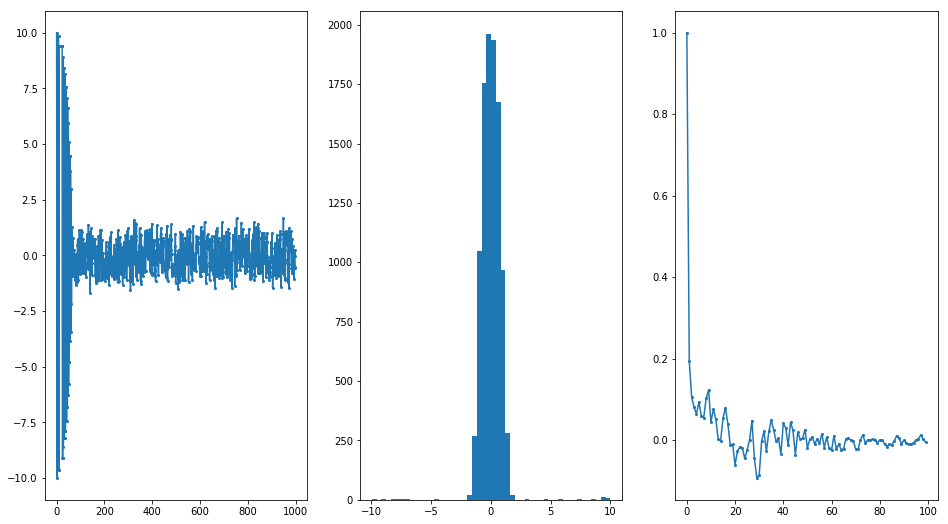

In [4]:
class IsingLongRange():
    def __init__(self, h, Jhat, N, beta = 0, accept_target = None):
        self.h = h
        self.Jhat = Jhat
        self.N = N
        self.beta = beta
        self.n_accepts = 0
        self.n_updates = 0
        self.accept_target = accept_target
        
    def phidot(self, p, phi):
        return p

    def pdot(self, p, phi):
        return - phi/(self.beta*self.Jhat) + self.N*np.tanh(self.beta*self.h + phi)
    
    def leapfrog(self, phi0, p0, eps, Nmd):
        pi = p0
        phi = phi0
        phi = phi + eps/2*self.phidot(pi, phi)
        
        for i in range(Nmd -1):
            pi = pi + eps*self.pdot(pi, phi)
            phi = phi + eps*self.phidot(pi, phi)
        
        pi = pi + eps*self.pdot(pi, phi)
        phi = phi + eps/2*self.phidot(pi, phi)
        
        return pi, phi
            
    def action(self, p, phi):
        return p**2/2 + phi**2/(2*self.beta*self.Jhat) - self.N*np.log(2*np.cosh(self.beta*self.h + phi))
        
    def sample_p(self):
        return np.random.normal()
        
    def hmc_sample(self, phi0, eps, Nmd):
        p0 = self.sample_p()
        pf, phif = self.leapfrog(phi0, p0, eps, Nmd)
        H0 = self.action(p0, phi0)
        Hf = self.action(pf, phif)
        dS = Hf - H0
        if np.random.uniform(0,1) < min(1, np.exp(-dS)):
            self.n_accepts += 1
        else:
            phif = phi0
            
        self.n_updates += 1
        
        # if self.accept_target and self.n_updates > 5:
            # accept_rate = self.n_accepts/self.n_updates
            
        
        return phif
        
        
        
beta = 1
h = 0.0
J = 1

N = 10
Jhat = J/N

traj = 1
Nmd = 10
eps = traj/Nmd

ising = IsingLongRange(h, Jhat, N, beta)

phi = 10
phi_values = []
Ncorr = 1
Ntherm = 0*Ncorr

for i in range(10000):
    phi = ising.hmc_sample(phi, eps, Nmd)
    if i>Ntherm and (i%Ncorr)==0:
        phi_values.append(phi)

print(ising.n_accepts/ising.n_updates)
fig, [ax1,ax2,ax3] = plt.subplots(1, 3, figsize = [16,9])

ac = autocorr(phi_values)
ac = ac/ac[0]


time = np.arange(len(phi_values))
Nplot = 1000
ax1.plot(time[:Nplot], phi_values[:Nplot], 'o-', markersize = 2)
# ax1.grid()
ax2.hist(phi_values, bins=50);

def acf(x, length=100):
    return np.array([1]+[np.corrcoef(x[:-i], x[i:])[0,1]  \
        for i in range(1, length)])

ac = acf(phi_values)
try:
    ac_tau = np.arange(ac.size)[np.where(np.abs(ac<1/np.exp(1)))[0][0]]
    print(ac_tau)
except ValueError:
    print('No autocorr value within 100 steps')
ax3.plot(np.arange(len(ac)), ac, 'o-', markersize = 2)

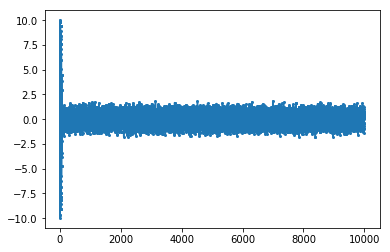

In [5]:
plt.plot(phi_values, 'o-', markersize = 2)

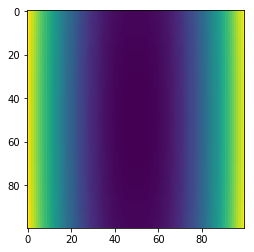

In [6]:
phi_grid, p_grid = np.meshgrid(np.linspace(-10, 10, 100), np.linspace(-4, 4, 100))
plt.imshow(ising.action(p_grid, phi_grid))

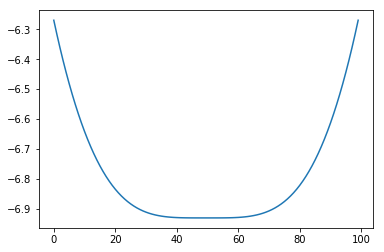

In [7]:
plt.plot(ising.action(0, np.linspace(-1,1,100)))

# Baryon correlators

In [8]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import uncertainties as uc
from uncertainties import unumpy as unp


In [10]:
from baryon_correlators import load_data_const_vol, bootstrap

1


In [41]:
from pprint import pprint
import glob
folder_names = glob.glob('RC*')
pprint(folder_names)

const_volume = list(sorted(folder_names[slice(1,6,2)]))
const_something = folder_names[slice(0,5,2)]

const_volume

['RC32x64_Kud01370000Ks01364000',
 'RC20x40_Kud01370000Ks01364000',
 'RC32x64_Kud01375400Ks01364000',
 'RC16x32_Kud01382500Ks01371000',
 'RC32x64_Kud01372700Ks01364000',
 'RC28x56_Kud01356000Ks01351000']


['RC16x32_Kud01382500Ks01371000',
 'RC20x40_Kud01370000Ks01364000',
 'RC28x56_Kud01356000Ks01351000']

In [12]:
for folder in folder_names:
    print('====')
    a = np.array(np.unique([f[-14] for f in glob.glob(folder+'/CPEvenism64_jsm64_txt/*')], return_counts = True))
    print(a.T)
    a = np.array(np.unique([f[-14] for f in glob.glob(folder+'/P15ism64_jsm64_txt/*')], return_counts = True))
    print(a.T)

====
[['b' '399']]
[]
====
[['1' '271']
 ['2' '329']
 ['3' '100']
 ['4' '90']]
[]
====
[['a' '200']
 ['b' '250']]
[]
====
[['1' '610']
 ['2' '190']]
[['1' '610']
 ['2' '190']]
====
[['b' '400']]
[]
====
[['1' '440']
 ['2' '210']]
[]


In [40]:
data = []
i = 0
for folder in sorted(const_volume):
    print(folder)
    print(i)
    i+=1
    data.append(load_data_const_vol(folder+'/CPEvenism64_jsm64_txt'))

    ind = [int(c) for c in data[-1].columns]
    
    # check indx start, stop, step size, length, and if length is correct
    print(ind[0], ind[-1], ind[1]-ind[0], len(ind), ind[0] + (ind[1] -ind[0])*(len(ind)-1) == ind[-1])
   

RC16x32_Kud01382500Ks01371000
0
410 6500 10 610 True
RC20x40_Kud01370000Ks01364000
1
510 3210 10 271 True
RC28x56_Kud01356000Ks01351000
2
510 4900 10 440 True


In [122]:
vols = [f[2:f.find('_')] for f in const_volume]
vols
const_volume

['RC16x32_Kud01382500Ks01371000',
 'RC20x40_Kud01370000Ks01364000',
 'RC28x56_Kud01356000Ks01351000']

In [119]:
const_volume
kud = [10*float('0.'+f[11:19]) for f in const_volume]
ks  = [10*float('0.'+f[21:29]) for f in const_volume]

for i in range(3):
    print("{:7} {:7}".format(kud[i], ks[i]))

0.13825  0.1371
  0.137  0.1364
 0.1356  0.1351


[699.0+/-0.3, 547.6+/-0.3, 409.7+/-0.7]


M_N  0.910+/-0.006
M_N* 1.274+/-0.006

M_N  0.731+/-0.006
M_N* 1.001+/-0.010

M_N  0.5282+/-0.0012
M_N* 0.723+/-0.004


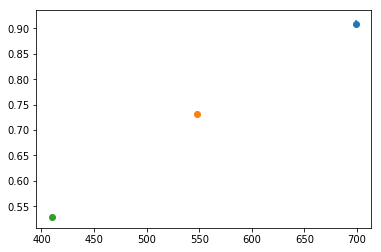

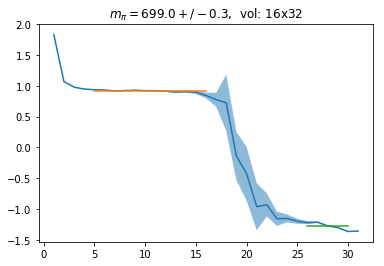

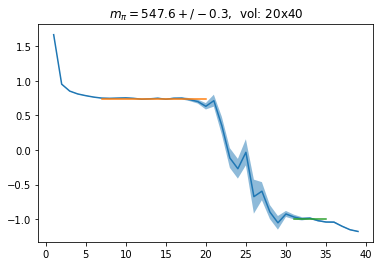

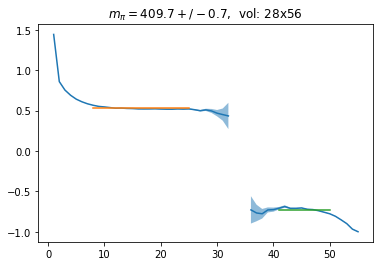

In [366]:
platvals = [[4,16,25,30],
            [6,20,30,35],
            [7,25,40,50]]

fig = plt.figure()
ax = fig.add_subplot(111)

mpi_vals = [uc.ufloat(699, 0.3), uc.ufloat(547.6, 0.3), uc.ufloat(409.7, 0.7)]

for mpi, vol, df, [pl1a, pl1b, pl2a, pl2b] in zip(mpi_vals, vols, data, platvals):
    plt.figure()
    plt.title("$m_\pi={:f.4}$,  vol: {}".format(mpi, vol))
    values = df.values.T
    
    Ma, Mb = bootstrap(values, plateau1 = slice(pl1a, pl1b), plateau2 = slice(pl2a, pl2b))
    print('')
    print("M_N ",Ma)
    print("M_N*",Mb)
    ax.errorbar(mpi.n, Ma.n, yerr = Ma.s, marker='o')

In [279]:
total_choices = []

In [343]:
def bootstrap_v2(values, Nstop = 20, K = 50):
    Nsamples, Nt = values.shape
    indx = np.arange(Nsamples)
    times = np.arange(Nt)

    fvalues = np.log(values[:,:-1]/values[:,1:])[:, :Nstop]
    means = []
    for i in range(K):
        choice = np.random.randint(0, Nsamples, size = 18)
        mean = np.nanmean(fvalues[choice], axis = 0)
        means.append(mean)

    m = np.mean(means,axis=0)
    s = np.std(means,axis=0)
    return m, s

    
values = df.values.T

/home/halvard/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: RuntimeWarning: invalid value encountered in log
  


0.5279+/-0.0013


/home/halvard/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: RuntimeWarning: invalid value encountered in log
  


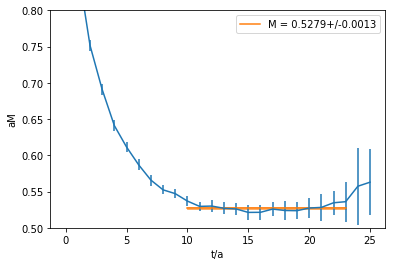

In [361]:
def fit_mass(m, times = None, Nstart=13, Nstop=20):
    if times is None:
        times = np.arange(m.shape[0])
    fit_mask = slice(Nstart,Nstop)
    fit_times = times[fit_mask]
    M, [[err]] = np.polyfit(fit_times, m[fit_mask], deg=0, cov=True)
    M = uc.ufloat(M, np.sqrt(err))
    print(M)

    plt.errorbar(times, y = m, yerr = s);
    ones = np.ones_like(fit_times)
    plt.plot(fit_times, M.n*ones, label = 'M = '+str(M))
    plt.fill_between(fit_times, (M.n - M.s)*ones, (M.n + M.s)*ones, alpha = 0.5, color='C1')
    plt.ylim([0.5,0.8])
    plt.ylabel('aM')
    plt.xlabel('t/a')
    plt.legend()
   
Nstop = 26
m,s = bootstrap_v2(values, Nstop=Nstop) 
fit_mass(m, Nstart = 10, Nstop = 24)

0.5267+/-0.0013


/home/halvard/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: RuntimeWarning: invalid value encountered in log
  


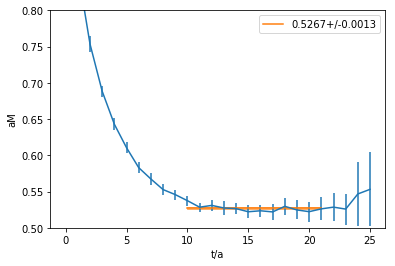

In [203]:
plt.xlabel('t/a', fontsize=16)
plt.ylabel('aM', fontsize=16)

TypeError: errorbar() missing 1 required positional argument: 'y'

In [157]:
K = 50
for i in range(K):
    choice = np.random.randint(Nsamples, size=Nsamples)
    avg    = np.mean(fvalues[choice], axis=0)
    std    = np.std(fvalues[choice], axis=0)

    samples.append([avg, std])

samples = np.array(samples)

(56, 439)


/home/halvard/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: RuntimeWarning: invalid value encountered in log
  


/home/halvard/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: RuntimeWarning: invalid value encountered in log
  This is separate from the ipykernel package so we can avoid doing imports until


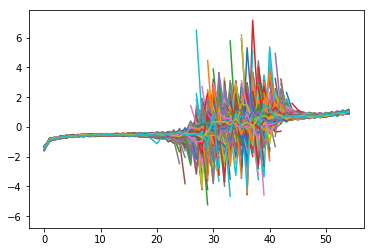

In [140]:
func_values = np.log(values[1:]/values[:-1])

plt.plot(func_values);

In [ ]:
a = uc.ufloat(1,2)
a

In [ ]:
unp.log(a)

In [ ]:
vals = unp.uarray(mean, std)

indx = np.arange(mean.size-1)
ratio = vals[1:]/vals[:-1]

mask = ratio > 0
logs = unp.log(ratio[mask])
indx = indx[mask]

In [ ]:
log_mean = np.array([np.abs(l.nominal_value) for l in logs])
log_std  = np.array([l.std_dev for l in logs])

plt.plot(indx, log_mean)
plt.fill_between(indx, y1=log_mean-log_std, y2 = log_mean + log_std, alpha = 0.5)
plt.ylim([0,3.2])
plt.ylabel(r'$\log(\frac{C(t)}{C(t+a)})$')

In [ ]:
vals[0].nominal_value

In [ ]:
plt.plot(np.log(mean[:-1]/mean[1:]))
#plt.yscale('log')

In [ ]:
plt.xscale('log')

for i in range(20):
    plt.hist(values[:,i],density=True)
    print(np.std(values[:,i])/np.mean(values[:,i]))

In [ ]:
tips = sns.load_dataset("fmri")